In [9]:
import os
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import scipy
from utils._bootstrap import bootstrap

n_max = 7
filenames = [glob.glob(f'../results/CoLLie/comparison_n{n+1}_*.csv')[0] for n in range(n_max)]

dfs = []
for n,filename in enumerate(filenames):
    if n == 0:
        continue
    df_n = pd.read_csv(filename)
    df_n['n'] = n+1
    dfs.append(df_n)

df = pd.concat(dfs, ignore_index=True)
df['lars_imp_rel_err'] = np.abs(df['lars_imp_loss'] - df['cvx_loss']) / df['cvx_loss']
df['lars_imp_rel_time'] = df['lars_imp_time'] / df['cvx_time']

df = df.dropna(subset=['cvx_loss'])

In [10]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                      '#f781bf', '#a65628', '#984ea3',
                      '#999999', '#e41a1c', '#dede00']
COLLIE = "CoLLie"
CVXPY = "CVXOPT"
CONF = 0.682689 # 1 sigma
linewidth = 2.0
markersize = 10.0
def plot_time(ax):
    ns = list(range(2,n_max+1))
    lars_time_mean = df.groupby('n')['lars_imp_time'].mean()
    ax.plot(ns,lars_time_mean,'o-',color=CB_color_cycle[2], label=COLLIE, markersize=markersize, linewidth=linewidth)
    intervals = [bootstrap(np.array(df[df['n']==n]['lars_imp_time']).reshape(1,-1),np.mean,vectorized=True,confidence_level=CONF).confidence_interval for n in ns]
    lows = [i.low for i in intervals]
    highs = [i.high for i in intervals]
    ax.fill_between(ns,lows,highs, alpha=0.3, color=CB_color_cycle[2])

    cvx_time_mean = df.groupby('n')['cvx_time'].mean()
    ax.plot(ns,cvx_time_mean,'o-',color=CB_color_cycle[3], label=CVXPY, markersize=markersize, linewidth=linewidth)
    intervals = [bootstrap(np.array(df[df['n']==n]['cvx_time']).reshape(1,-1),np.mean,vectorized=True,confidence_level=CONF).confidence_interval for n in ns]
    lows = [i.low for i in intervals]
    highs = [i.high for i in intervals]
    ax.fill_between(ns,lows,highs, alpha=0.3,color=CB_color_cycle[3])

def plot_errors(ax):
    ns = list(range(2,n_max+1))
    lars_err_mean = df.groupby('n')['lars_imp_rel_err'].mean()
    ax.plot(ns,lars_err_mean,'o-',color=CB_color_cycle[2], label=COLLIE, markersize=markersize, linewidth=linewidth)
    ax.plot(ns,np.zeros_like(ns),'o-',color=CB_color_cycle[3], label=CVXPY, markersize=markersize, linewidth=linewidth)
    intervals = [bootstrap(np.array(df[df['n']==n]['lars_imp_rel_err']).reshape(1,-1),np.mean,vectorized=True,confidence_level=CONF).confidence_interval for n in ns]
    lows = [i.low for i in intervals]
    highs = [i.high for i in intervals]
    ax.fill_between(ns,lows,highs, alpha=0.3, color=CB_color_cycle[2])

# plt.yscale('log')

C:\Users\krkac\AppData\Local\Temp\ipykernel_27904\3647836378.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels([2,5,7], fontsize=ticks_fontsize)


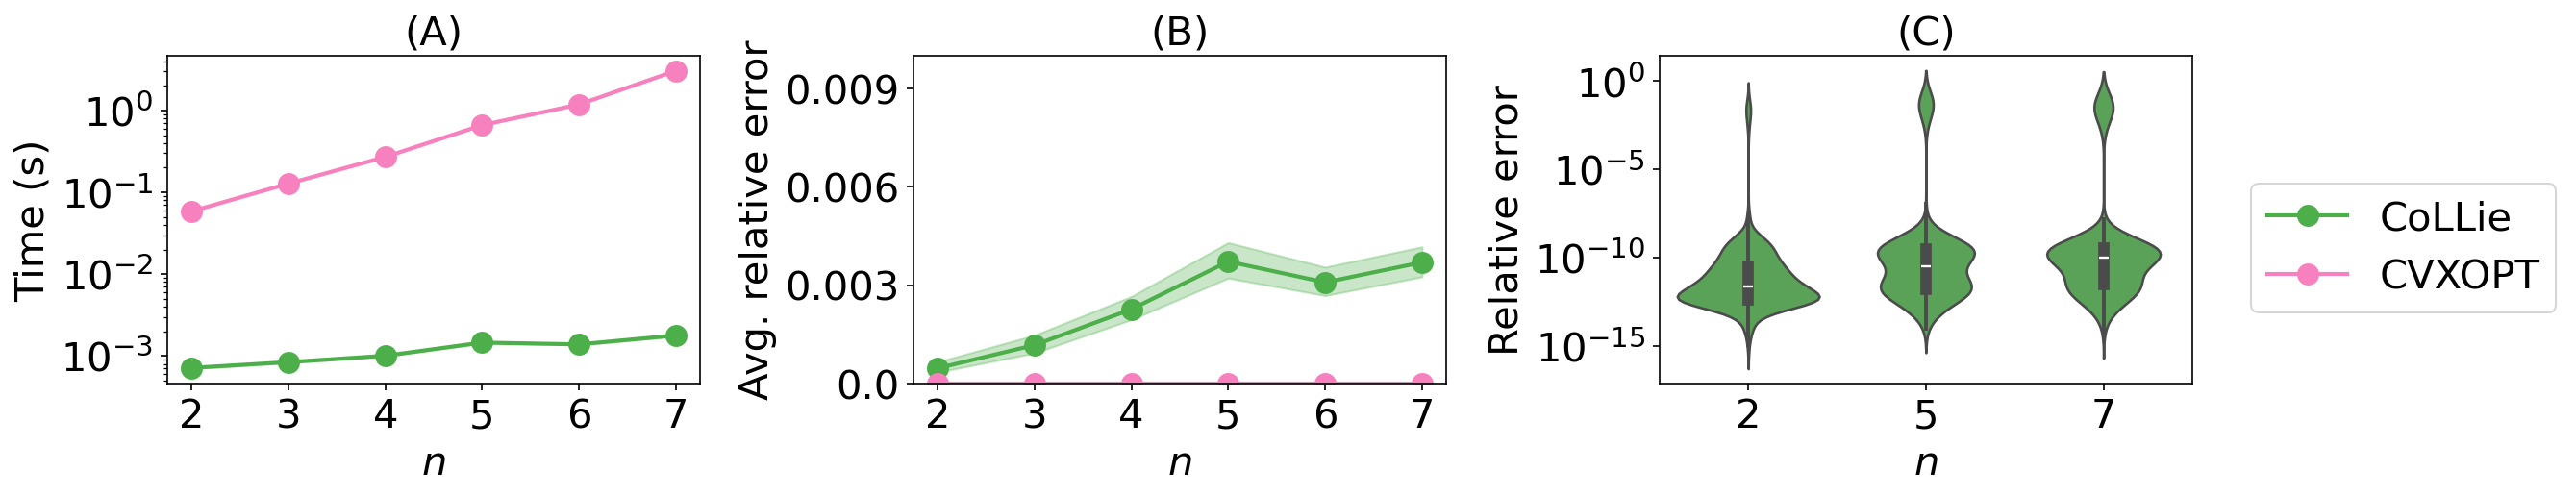

In [11]:
xlabel_fontsize = 20
ylabel_fontsize = 20
legend_fontsize = 20
title_fontsize = 20
ticks_fontsize = 20
fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(18,3.5),dpi=150)
ax1.set_xlabel(r'$n$',fontsize=xlabel_fontsize)
ax1.set_ylabel('Time (s)',fontsize=ylabel_fontsize)
ax1.set_xticks([2,3,4,5,6,7])
ax1.set_xticklabels([2,3,4,5,6,7], fontsize=ticks_fontsize)
ax1.set_yscale('log')
ax1.set_yticks([0.001,0.01,0.1,1])
ax1.set_yticklabels(['$10^{-3}$',r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$'], fontsize=ticks_fontsize)
ax1.title.set_text("(A)")
ax1.title.set_fontsize(title_fontsize)
plot_time(ax1)


plot_errors(ax2)
ax2.set_ylim(0.0,0.01)
ax2.set_xlabel(r'$n$',fontsize=xlabel_fontsize)
ax2.set_ylabel('Avg. relative error',fontsize=ylabel_fontsize)
ax2.set_xticks([2,3,4,5,6,7])
ax2.set_xticklabels([2,3,4,5,6,7], fontsize=ticks_fontsize)
ax2.set_yticks([0.000,0.003,0.006,0.009])
ax2.set_yticklabels([0.000,0.003,0.006,0.009], fontsize=ticks_fontsize)
ax2.title.set_text("(B)")
ax2.title.set_fontsize(title_fontsize)

tab = df[['n','lars_imp_rel_err']]
tab = tab[(tab['n']==2)|(tab['n']==5)|(tab['n']==7)]
table = pd.melt(tab,id_vars=['n'],value_vars=['lars_imp_rel_err'])
table['value'] = np.log10(table['value'])
g = sns.violinplot(ax=ax3,y='value',x='n',data=table,color=CB_color_cycle[2])
g.set_yticks([-15,-10,-5,0])
g.set_yticklabels([r'$10^{-15}$',r'$10^{-10}$',r'$10^{-5}$',r'$10^{0}$'],fontsize=ticks_fontsize)
g.set_xticklabels([2,5,7], fontsize=ticks_fontsize)
g.set_ylabel('Relative error',fontsize=ylabel_fontsize)
g.set_xlabel(r'$n$',fontsize=xlabel_fontsize)
g.title.set_text("(C)")
g.title.set_fontsize(title_fontsize)

# fig.suptitle("Performance of CoLLie compared to CVXPY", fontsize=title_fontsize)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels,loc='center right',fontsize=legend_fontsize)
plt.subplots_adjust(left=0.07,
                    bottom=0.2, 
                    right=0.85, 
                    top=0.85, 
                    wspace=0.4, 
                    hspace=0.3)

plt.savefig('figures/Figure_2.pdf')